# IE440 Final Assignment

M. Akın Elden

In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

### Useful Functions

In [263]:
def plotClusters(dataArrays, clusterPoints, colors, title, figsize=[6.4, 4.8], name="graph"):
    if len(dataArrays) != len(clusterPoints) or len(dataArrays) != len(colors):
        print("Data, cluster points and colors size doesn't match!")
        return
    plt.figure(figsize=figsize)
    for i in range(len(dataArrays)):
        plt.scatter(dataArrays[i]['x'], dataArrays[i]['y'], color=colors[i], marker=".", alpha=0.6)
        plt.scatter(clusterPoints[i]['x'], clusterPoints[i]['y'], color=colors[i], marker="p", s=200, edgecolors="black")
    plt.title(title)
    #plt.savefig("{0}.png".format(name))

In [318]:
def plotTSPMap(cities_data, route, title, figsize=[6.4, 4.8], name="graph"):
    plt.figure(figsize=figsize)
    plt.scatter(cities_data["x"], cities_data["y"], color="green", marker="o", label="Cities")
    if len(route) > 0:
        plt.plot(route[:,0], route[:,1], 'b-', label="Route")
        plt.plot(route[[-1,0],0], route[[-1,0],1], 'b-')
    plt.title(title)
    plt.legend()
    #plt.savefig("{0}.png".format(name))

## Part 1 : Clustering

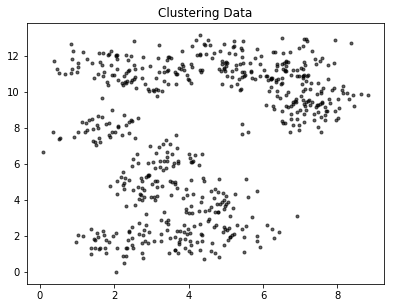

In [265]:
cluster_data = pd.read_csv('IE440Final19ClusteringData.txt', sep='\t', header=0);

cluster_centers = cluster_data.copy()[0:0]
patterns = np.array(cluster_data)[:,:-1]

plotClusters([cluster_data], [cluster_centers], ["black"], "Clustering Data")

In [266]:
# Used to assign data points to cluster centers
def splitClusters(x, w, b):
    data = pd.DataFrame(x.reshape(-1,2), columns=["x", "y"])
    clusters = []
    centers = []
    for i in range(len(w)):
        clusters.append(data[b[i] == 1])
        centers.append(pd.DataFrame(w[i].reshape(1,2), columns=["x","y"]))
    return clusters, centers

In [267]:
def findBestTrial(patterns, cluster_number, clustering_function, trial_number=10000, seed=440):
    np.random.seed(seed)
    z = np.inf
    b = []
    w = []
    x = []
    for i in range(trial_number):
        x_t, b_t, w_t, z_t = clustering_function(patterns, cluster_number)
        if z_t < z:
            z = z_t
            b = b_t
            w = w_t
            x = x_t
    return x, b, w, z

### a. K-means (batch)

In [302]:
def KMeans_batch(patterns, cluster_number):
    I = cluster_number
    P = np.size(patterns,0)
    K = np.size(patterns,1)
    t = 1
    z_prev = np.inf
    randIndices = np.random.choice(range(P), I, replace=False)
    w_t = np.copy(patterns)[randIndices]
    b_prev = np.zeros((I,P))
    while(True):
        b_t = np.zeros((I,P))
        for p in range(P):
            ip = np.linalg.norm(patterns[p] - w_t, axis=1).argmin()
            b_t[ip,p] = 1
        z_t = 0
        assg_indices = np.argwhere(b_t > 0.5)
        for i in assg_indices:
            z_t += np.sum( (patterns[i[1]] - w_t[i[0]])**2 )
        w_tp = np.copy(w_t)
        for i in range(I):
            for k in range(K):
                w_tp[i,k] = (b_t[i]*patterns[:,k]).sum() / b_t[i].sum()
        if z_t >= z_prev:
            break
        t += 1
        z_prev = z_t
        b_prev = b_t
        w_t = w_tp
    return patterns, b_prev, w_t, z_prev

**Experiment for K=5**

Error value is: 1204.572591045545


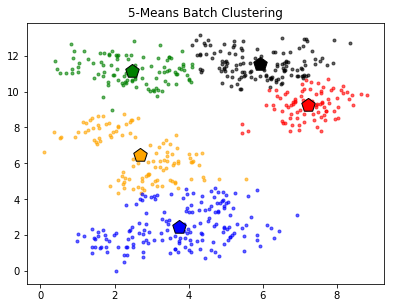

In [301]:
x, b, w, z = findBestTrial(patterns, 5, KMeans_batch, trial_number = 100, seed=440)
clusters, centers = splitClusters(x, w, b)
colors = ["black", "red", "orange", "green", "blue"]
plotClusters(clusters, centers, colors, "5-Means Batch Clustering")
print("Error value is: {0}".format(z))

**Experiment for K=10**

Error value is: 538.9474967809786


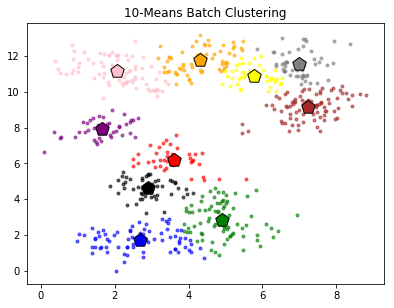

In [303]:
x, b, w, z = findBestTrial(patterns, 10, KMeans_batch, trial_number=100, seed=72)
clusters, centers = splitClusters(x, w, b)
colors = ["black", "red", "orange", "green", "blue", "yellow", "gray", "purple", "brown", "pink"]
plotClusters(clusters, centers, colors, "10-Means Batch Clustering")
print("Error value is: {0}".format(z))

**Experiment for K=15**

Error value is: 345.48188847517724


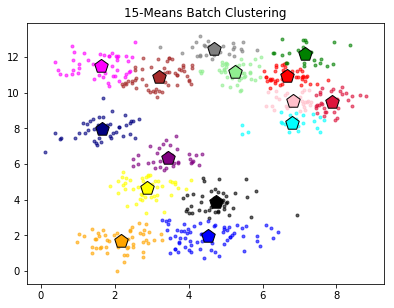

In [277]:
x, b, w, z = findBestTrial(patterns, 15, KMeans_batch, trial_number=100, seed=50)
clusters, centers = splitClusters(x, w, b)
colors = ["black", "red", "orange", "green", "blue", "yellow", "gray", "purple", "brown", "pink", "cyan", "magenta", "lightgreen", "navy","crimson"]
plotClusters(clusters, centers, colors, "15-Means Batch Clustering")
print("Error value is: {0}".format(z))

### b. K-means (online)

In [304]:
def KMeans_online(patterns, cluster_number, alpha = 0.8, moment = 0.9, epsilon=0.01):
    I = cluster_number
    P = np.size(patterns,0)
    K = np.size(patterns,1)
    t = 0
    z = np.inf
    randIndices = np.random.choice(range(P), I, replace=False)
    w = np.copy(patterns)[randIndices]
    b = np.zeros((I,P))
    x = np.copy(patterns)
    while(alpha > epsilon):
        np.random.shuffle(x)
        b = np.zeros((I,P))
        w_tp = np.copy(w)
        for p in range(P):
            ip = np.linalg.norm(x[p] - w, axis=1).argmin()
            b[ip,p] = 1
            delta_w_ip = alpha * (x[p] - w[ip])
            w_tp[ip] = w[ip] + delta_w_ip
        z = 0
        assg_indices = np.argwhere(b > 0.5)
        for i in assg_indices:
            z += np.sum( (x[i[1]] - w[i[0]])**2 )
        alpha = moment * alpha
        t += 1
        w = w_tp
    return x, b, w, z

**Experiment for K=5**

Error value is: 1321.8876605588036


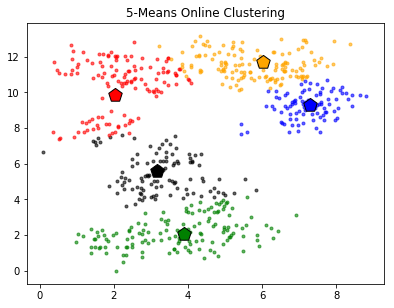

In [299]:
x, b, w, z = findBestTrial(patterns, 5, KMeans_online, trial_number = 5, seed=440)
clusters, centers = splitClusters(x, w, b)
colors = ["black", "red", "orange", "green", "blue"]
plotClusters(clusters, centers, colors, "5-Means Online Clustering")
print("Error value is: {0}".format(z))

**Experiment for K=10**

Error value is: 530.6415395055982


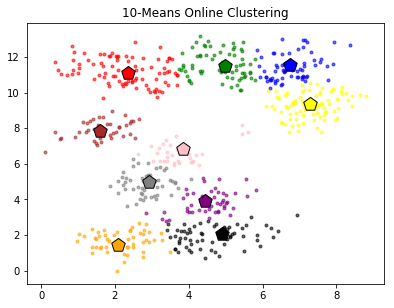

In [281]:
x, b, w, z = findBestTrial(patterns, 10, KMeans_online, trial_number = 100, seed=72)
clusters, centers = splitClusters(x, w, b)
colors = ["black", "red", "orange", "green", "blue", "yellow", "gray", "purple", "brown", "pink"]
plotClusters(clusters, centers, colors, "10-Means Online Clustering")
print("Error value is: {0}".format(z))

**Experiment for K=15**

Error value is: 364.3624962416157


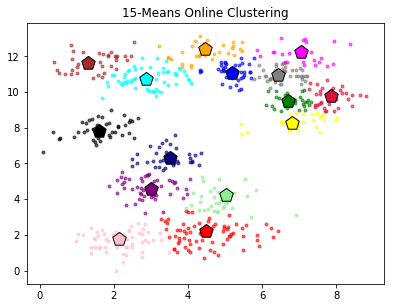

In [282]:
x, b, w, z = findBestTrial(patterns, 15, KMeans_online, trial_number=100, seed=50)
clusters, centers = splitClusters(x, w, b)
colors = ["black", "red", "orange", "green", "blue", "yellow", "gray", "purple", "brown", "pink", "cyan", "magenta", "lightgreen", "navy","crimson"]
plotClusters(clusters, centers, colors, "15-Means Online Clustering")
print("Error value is: {0}".format(z))

### c. Self-organizing map (SOM)

In [310]:
def SOM(patterns, cluster_number, alpha=0.9, beta=0.8, seed=440):
    np.random.seed(seed)
    I = cluster_number
    P = np.size(patterns,0)
    K = np.size(patterns,1)
    t = 0
    randIndices = np.random.choice(range(P), I, replace=False)
    w = np.copy(patterns)[randIndices]
    x = np.copy(patterns)
    sigma = (x[:,0].max() - x[:,0].min()) / 2
    while(t < 500):
        np.random.shuffle(x)
        w_tp = np.copy(w)
        for p in range(P):
            ip = np.linalg.norm(x[p] - w, axis=1).argmin()
            for i in range(I):
                gaussian_i = np.exp(-np.linalg.norm(w[i] - w[ip])**2 / sigma**2)
                delta_w_i = alpha * gaussian_i * (x[p] - w[i])
                w_tp[i] = w[i] + delta_w_i
        sigma = max(1e-8, beta * sigma) # To avoid divide by zero error
        if t < 1000:
            alpha = 0.9 * (1 - t / 1000)
        else:
            alpha = 1 / np.sqrt(t)
        t += 1
        w = w_tp
    return x, w

In [306]:
def findClusterClasses(x, w):
    I = np.size(w, 0)
    P = np.size(x, 0)
    b = np.zeros((I,P))
    for p in range(P):
        ip = np.linalg.norm(x[p] - w, axis=1).argmin()
        b[ip,p] = 1
    return b

In [307]:
def calculateError(b, x, w):
    z = 0
    assg_indices = np.argwhere(b > 0.5)
    for i in assg_indices:
        z += np.sum( (x[i[1]] - w[i[0]])**2 )
    return z

Error value is: 1276.2987658701877


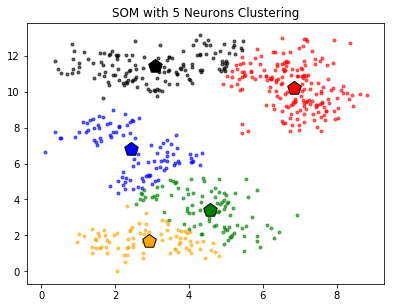

In [323]:
x, w = SOM(patterns, 5, seed=400)
b = findClusterClasses(x, w)
clusters, centers = splitClusters(x, w, b)
colors = ["black", "red", "orange", "green", "blue"]
plotClusters(clusters, centers, colors, "SOM with 5 Neurons Clustering")
z = calculateError(b, x, w)
print("Error value is: {0}".format(z))

Error value is: 778.8805674429349


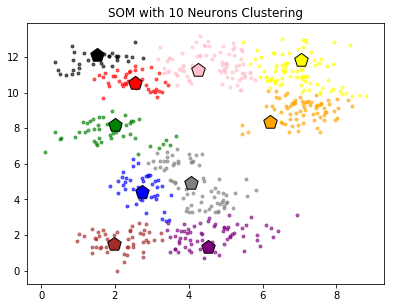

In [325]:
x, w = SOM(patterns, 10, seed=72)
b = findClusterClasses(x, w)
clusters, centers = splitClusters(x, w, b)
colors = ["black", "red", "orange", "green", "blue", "yellow", "gray", "purple", "brown", "pink"]
plotClusters(clusters, centers, colors, "SOM with 10 Neurons Clustering")
z = calculateError(b, x, w)
print("Error value is: {0}".format(z))

Error value is: 391.0225985086531


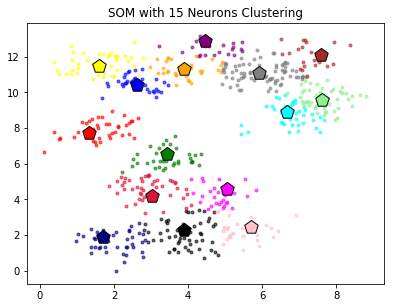

In [326]:
x, w = SOM(patterns, 15, seed=50)
b = findClusterClasses(x, w)
clusters, centers = splitClusters(x, w, b)
colors = ["black", "red", "orange", "green", "blue", "yellow", "gray", "purple", "brown", "pink", "cyan", "magenta", "lightgreen", "navy","crimson"]
plotClusters(clusters, centers, colors, "SOM with 15 Neurons Clustering")
z = calculateError(b, x, w)
print("Error value is: {0}".format(z))

## Part 2 : SOM for the Euclidean Travelling Salesman Problem

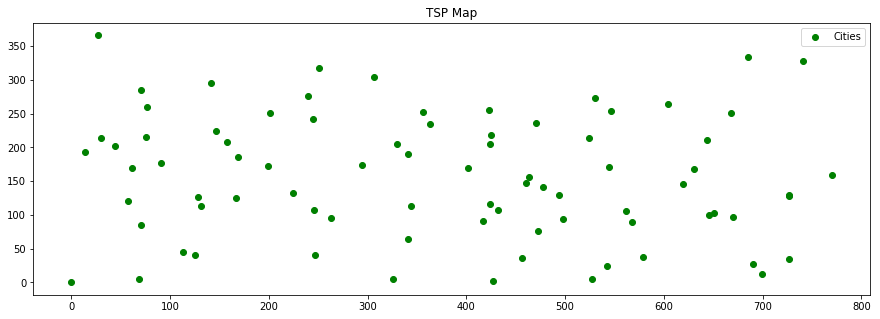

In [90]:
cities_data = pd.read_csv('IE440Final19ETSPData.txt', sep=',', header=0);

tsp_patterns = np.array(cities_data[["x","y"]])

plotTSPMap(cities_data, [], "TSP Map", [15, 5])

In [133]:
def totalTourLength(route):
    total = 0
    shifted_route = np.insert(route[1:], 80, route[0], axis=0)
    distances = np.linalg.norm(route[:,:-1]-shifted_route[:,:-1], axis=1)
    return np.sum(distances)

In [157]:
def findRoute(x, w):
    I = np.size(w, 0)
    P = np.size(x, 0)
    route = np.insert(x, 2, 0, axis=1)
    for p in range(P):
        ip = np.linalg.norm(x[p] - w, axis=1).argmin()
        route[p,2] = ip
    return route[route[:,2].argsort()]

### a. Exact solution

In [217]:
def plotTSPExactSolution(cities_data, pairs, title, figsize=[6.4, 4.8], name="graph"):
    plt.figure(figsize=figsize)
    plt.scatter(cities_data["x"], cities_data["y"], color="green", marker="o", label="Cities")
    for p in range(len(pairs)):
        pair_coordinates = cities_data.loc[[pairs.loc[p]["i"],pairs.loc[p]["j"]]]
        plt.plot(pair_coordinates["x"], pair_coordinates["y"], "b-")
    plt.title(title)
    #plt.savefig("{0}.png".format(name))

I solved the problem with Gurobi 8.0.1 solver.
Since the solver required Python 2.7, exact solution code is in another file named **"tsp_gurobi.py"**.

It's objective value is : **3904.21**

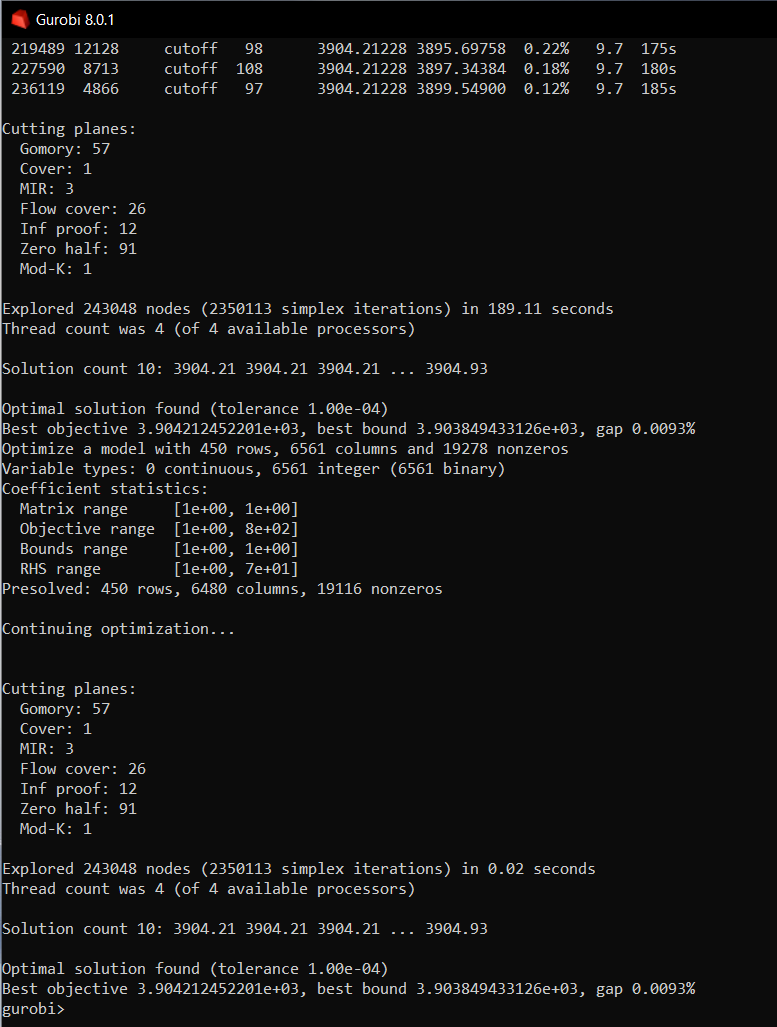

In [260]:
img = Image.open("gurobi_solution.png")
img

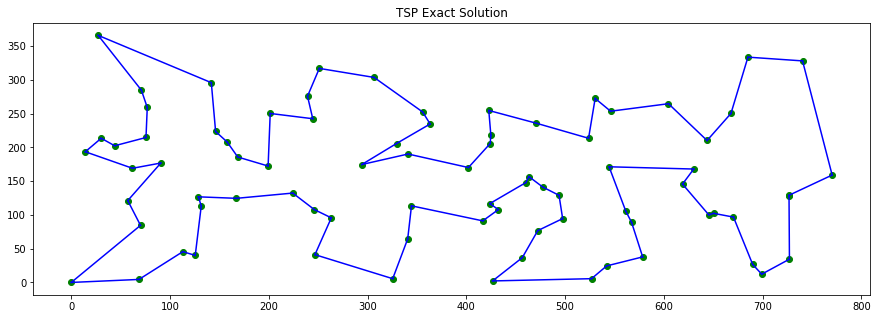

In [311]:
solution = pd.read_csv("solver_solution.csv", header=None, names = ["i", "j"])
plotTSPExactSolution(cities_data, solution, "TSP Exact Solution", [15,5])

### b. SOM-TSP with Gaussian Kernel Neighborhood

In [327]:
def initializeWeights(patterns, I):
    x_min = patterns[:,0].min()
    x_max = patterns[:,0].max()
    y_min = patterns[:,0].min()
    y_max = patterns[:,0].max()
    w = np.random.rand(I, 2)
    w[:,0] = x_min + w[:,0] * (x_max - x_min)
    w[:,1] = y_min + w[:,1] * (y_max - y_min)
    return w

In [328]:
def SOM_TSP(patterns, neurons_number, neighborhood_func, iteration_number, alpha=0.9, beta=0.9, seed=440):
    np.random.seed(seed)
    I = neurons_number
    P = np.size(patterns,0)
    t = 0
    w = initializeWeights(patterns, I)
    x = np.copy(patterns)
    #sigma = (x[:,0].max() - x[:,0].min()) / 2
    sigma = np.sqrt( (x[:,0].max() - x[:,0].min())**2 + (x[:,1].max() - x[:,1].min())**2 )
    while(t < iteration_number):
        np.random.shuffle(x)
        w_tp = np.copy(w)
        for p in range(P):
            ip = np.linalg.norm(x[p] - w, axis=1).argmin()
            for i in range(I):
                neighborhood = neighborhood_func(w, i, ip, I, sigma)
                delta_w_i = alpha * neighborhood * (x[p] - w[i])
                w_tp[i] = w[i] + delta_w_i
        sigma = max(1e-8, beta * sigma) # To avoid divide by zero error
        if t < 1000:
            alpha = 0.9 * (1 - t / 1000)
        else:
            alpha = 0.9995**t
        t += 1
        w = w_tp
    return x, w

#### Gaussian Kernel Neighborhood Function

In [329]:
def gaussian_kernel(w, i, ip, I, sigma):
    gaussian = np.exp(-np.linalg.norm(w[i] - w[ip])**2 / sigma**2)
    return gaussian

**SOM-TSP Gaussian with M=81**

In [ ]:
M = 81
x, w = SOM_TSP(tsp_patterns, M, elastic_band, 2000, beta=0.99, seed=50)
route = findRoute(x, w)
distance = totalLengthOfTour(route)
print("Total length of tour: {0}".format(distance))

In [ ]:
plotTSPMap(cities_data, route, "SOM-TSP Gaussian with 81 Neurons", [15, 5])

**SOM-TSP Gaussian with M=81*2**

In [ ]:
M = 81*2
x, w = SOM_TSP(tsp_patterns, M, elastic_band, 2000, beta=0.99, seed=50)
route = findRoute(x, w)
distance = totalLengthOfTour(route)
print("Total length of tour: {0}".format(distance))

In [ ]:
plotTSPMap(cities_data, route, "SOM-TSP Gaussian with 81*2 Neurons", [15, 5])

**SOM-TSP Gaussian with M=81*3**

In [ ]:
M = 81*3
x, w = SOM_TSP(tsp_patterns, M, elastic_band, 2000, beta=0.99, seed=50)
route = findRoute(x, w)
distance = totalLengthOfTour(route)
print("Total length of tour: {0}".format(distance))

In [ ]:
plotTSPMap(cities_data, route, "SOM-TSP Gaussian with 81*3 Neurons", [15, 5])

**Conclusion**

Since Gaussian Kernel neighborhood doesn't provide a sequence for the neurons; even if two neurons are close to each other, difference between their indices can be very large. Therefore using Gaussian Kernel neighborhood for TSP is meaningless.

### c. SOM-TSP with Elastic Band Neighborhood

#### Elastic Band Neighborhood Function

In [76]:
def elastic_band(w, i, ip, I, sigma):
    d = min(abs(i-ip), I - abs(i-ip))
    elastic_neigh = np.exp(-d**2 / sigma**2)
    return elastic_neigh

**SOM-TSP with M=81**

In [ ]:
M = 81
x, w = SOM_TSP(tsp_patterns, M, elastic_band, 2000, beta=0.99, seed=50)
route = findRoute(x, w)
distance = totalLengthOfTour(route)
print("Total length of tour: {0}".format(distance))

In [ ]:
plotTSPMap(cities_data, route, "SOM-TSP with 81 Neurons", [15, 5])

**SOM-TSP with M=81*2**

In [ ]:
M = 81*2
x, w = SOM_TSP(tsp_patterns, M, elastic_band, 2000, beta=0.99, seed=21)
route = findRoute(x, w)
distance = totalLengthOfTour(route)
print("Total length of tour: {0}".format(distance))

In [ ]:
plotTSPMap(cities_data, route, "SOM-TSP with 81*2 Neurons", [15, 5])

**SOM-TSP with M=81*3**

In [ ]:
M = 81*3
x, w = SOM_TSP(tsp_patterns, M, elastic_band, 2000, beta=0.99, seed=90)
route = findRoute(x, w)
distance = totalLengthOfTour(route)
print("Total length of tour: {0}".format(distance))

In [ ]:
plotTSPMap(cities_data, route, "SOM-TSP with 81*3 Neurons", [15, 5])

**SOM-TSP with M=81*6**

In [ ]:
M = 81*6
x, w = SOM_TSP(tsp_patterns, M, elastic_band, 2000, beta=0.99, seed=33)
route = findRoute(x, w)
distance = totalLengthOfTour(route)
print("Total length of tour: {0}".format(distance))

In [ ]:
plotTSPMap(cities_data, route, "SOM-TSP with 81*6 Neurons", [15, 5])

**SOM-TSP with M=81*10**

In [330]:
x1, w1 = SOM_TSP(tsp_patterns, 81*10, elastic_band, 2000, beta=0.99, seed=400)
route = findRoute(x1, w1)
totalLengthOfTour(route)

KeyboardInterrupt: 

In [ ]:
plotTSPMap(cities_data, route, "SOM-TSP with 81*10 Neurons", [15, 5])

In [206]:
M = 81*10
x1, w1 = SOM_TSP(tsp_patterns, M, elastic_band, 2000, beta=0.99, seed=400)
route = findRoute(x1, w1)
distance = totalLengthOfTour(route)
print("Total length of tour: {0}".format(distance))

4106.74295804903

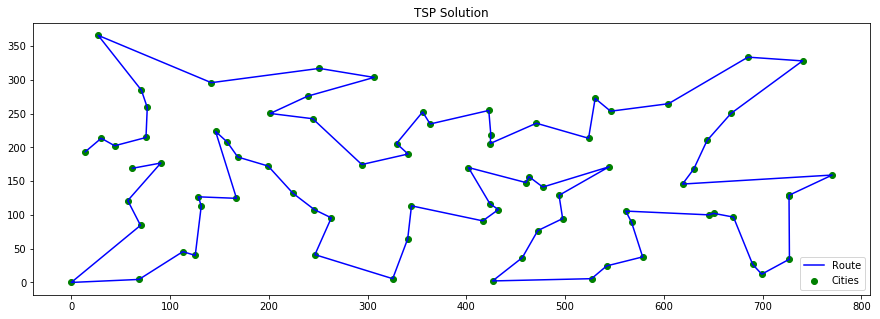

In [207]:
plotTSPMap(cities_data, route, "SOM-TSP with 81*10 Neurons", [15, 5])

In [ ]:
route = findRoute(x, w)
print(totalLengthOfTour(route))
plotTSPMap(cities_data, route, "TSP Solution", [15, 5])

In [144]:
x1, w1 = SOM_TSP(tsp_patterns, 81*5, 200, elastic_band, beta=0.9, seed=400)
route = findRoute(x1, w1)
totalLengthOfTour(route)

4601.942083100103

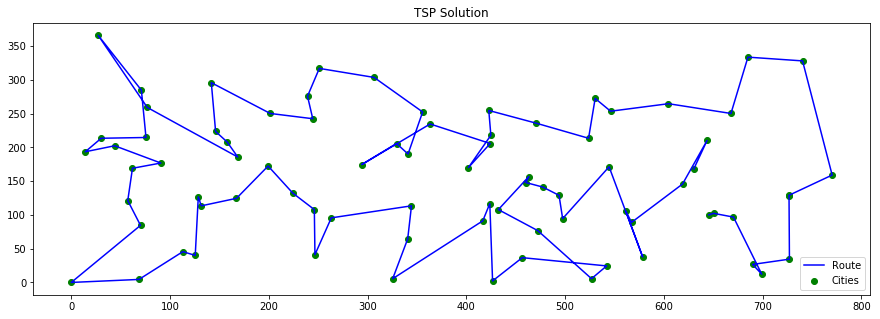

In [145]:
plotTSPMap(cities_data, route, "TSP Solution", [15, 5])

In [213]:
x5, w5 = SOM_TSP(tsp_patterns, 81*10, elastic_band, beta=0.98, seed=25)
route = findRoute(x5, w5)
totalLengthOfTour(route)

4118.134168503644

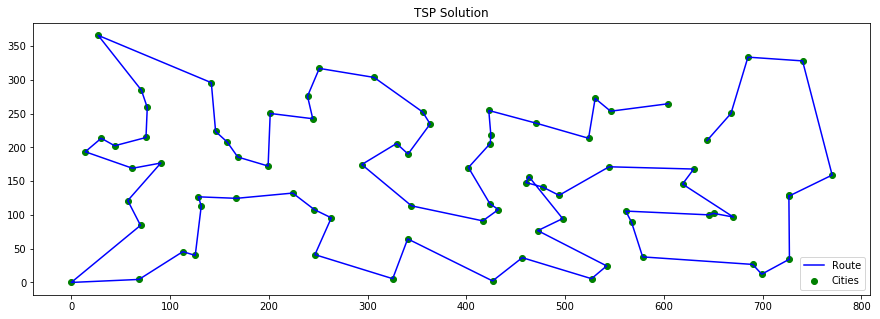

In [214]:
plotTSPMap(cities_data, route, "TSP Solution", [15, 5])

In [215]:
x6, w6 = SOM_TSP(tsp_patterns, 81*10, elastic_band, beta=0.99, seed=400)
route = findRoute(x6, w6)
totalLengthOfTour(route)

4108.248636663435

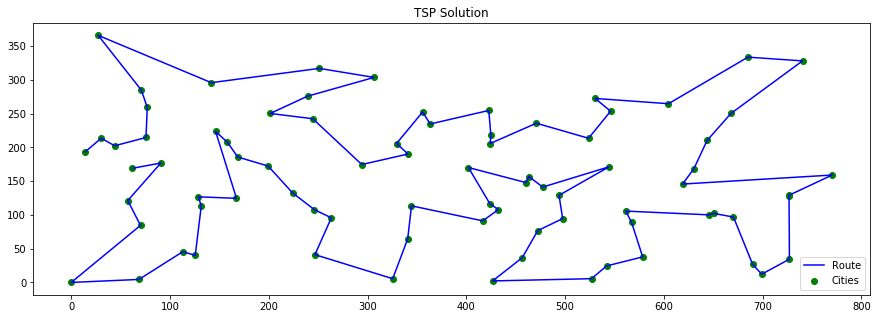

In [216]:
plotTSPMap(cities_data, route, "TSP Solution", [15, 5])